# Training a Spiking Convolutional Neural Network for analysing DVS data

In this tutorial, we will train a **spiking convolutional neural network** in the most direct way: by training a normal CNN first, and then transferring the parameters we learned onto the spiking network.

We train the network on the [MNIST-DVS](http://www2.imse-cnm.csic.es/caviar/MNISTDVS.html) dataset, which consists of MNIST digits (handwritten digits from 0 to 9) recorded with a DVS (dynamic vision sensor). DVSs are event-based sensors, whose data are well suited for elaboration in spiking networks (which are also based on events, the spikes). This is how the dataset looks like:

![MNIST-DVS digit](https://drive.google.com/uc?id=1BsFc8x54_drHy7uB4qqhnVkuMXS8u58C)

but remember that it's a stream of individual events, not frames! The data looks like this:
```
# x    y    time         polarity
  203  129  1564882943   0
  21   212  1564882951   1
  ...
```

In order to train the CNN, we accumulate these events into frames, which are static pictures. I already did that for you, and the dataset will be downloaded below.

## Installs and downloads

Download some data we will use later. Some of this data is an elaboration of the MNIST_DVS dataset from the Seville Microelectronics Institute.

In [1]:
! wget -O mnist_dvs_train_frames.zip https://www.dropbox.com/s/dl/lni9tyspaykxq0d/train.zip
! unzip -q mnist_dvs_train_frames.zip

--2020-01-22 16:03:00--  https://www.dropbox.com/s/dl/lni9tyspaykxq0d/train.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0069f2cdbfbaa84b446af4977f.dl.dropboxusercontent.com/cd/0/get/AwpFS4bmRm4qHESG7yIu3oG-FbkZ4rs5QqbZ1F3xQogqO_cStsVA9qruIa7q3gTrE1O5PbuPartEVn6cf0WBG9H_0NWaJEFVuzTjL8gWMYINiaN_nveymQgsnEKMZ8l6IWw/file?dl=1# [following]
--2020-01-22 16:03:01--  https://uc0069f2cdbfbaa84b446af4977f.dl.dropboxusercontent.com/cd/0/get/AwpFS4bmRm4qHESG7yIu3oG-FbkZ4rs5QqbZ1F3xQogqO_cStsVA9qruIa7q3gTrE1O5PbuPartEVn6cf0WBG9H_0NWaJEFVuzTjL8gWMYINiaN_nveymQgsnEKMZ8l6IWw/file?dl=1
Resolving uc0069f2cdbfbaa84b446af4977f.dl.dropboxusercontent.com (uc0069f2cdbfbaa84b446af4977f.dl.dropboxusercontent.com)... 162.125.9.6, 2620:100:601b:6::a27d:806
Connecting to uc0069f2cdbfbaa84b446af4977f.dl.dropboxusercontent.

In [2]:
! wget -O number_dvs_recording.npz https://www.dropbox.com/s/dl/k4084yjkfobyr85/number_dvs_recording.npz

--2020-01-22 16:03:29--  https://www.dropbox.com/s/dl/k4084yjkfobyr85/number_dvs_recording.npz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc71dfdf13547ef32c34da6db9e.dl.dropboxusercontent.com/cd/0/get/AwqK7s-BPqSi0aswFfki9qEbFtqeUsKQv_ZtZVpNVRjMJaiIj_-GMnJnM5vHzguRgPyLaAkx4Qts0yQpk4YIqznv5inOzCoQXaHWaJi-RXQBAc_6ODenDBfxg-lDWtlVuGE/file?dl=1# [following]
--2020-01-22 16:03:30--  https://ucc71dfdf13547ef32c34da6db9e.dl.dropboxusercontent.com/cd/0/get/AwqK7s-BPqSi0aswFfki9qEbFtqeUsKQv_ZtZVpNVRjMJaiIj_-GMnJnM5vHzguRgPyLaAkx4Qts0yQpk4YIqznv5inOzCoQXaHWaJi-RXQBAc_6ODenDBfxg-lDWtlVuGE/file?dl=1
Resolving ucc71dfdf13547ef32c34da6db9e.dl.dropboxusercontent.com (ucc71dfdf13547ef32c34da6db9e.dl.dropboxusercontent.com)... 162.125.9.6, 2620:100:601b:6::a27d:806
Connecting to ucc71dfdf13547ef32c34da6db9e.dl.drop

Install `sinabs`, our library for Spiking Convolutional Networks

In [3]:
% pip install sinabs

     |████████████████████████████████| 71kB 809kB/s 


## Loading and understanding spiking data

Let's start by using the original DVS data, made of **events**, not frames. The file `number_dvs_recording.npz` contains a DVS stream that I recorded myself, standing in front of a DVS with numbers written on paper. It's not part of the MNIST-DVS dataset.

In [24]:
import numpy as np

# loading a DVS recording
File = np.load('number_dvs_recording.npz')

t, x, y = File['t'], File['x'], File['y']

len(t)

1266532

t, x, y now contain the times and locations of DVS events. Find a way to visualize this data in order to understand it a bit better.

Text(0, 0.5, 'Number of spikes')

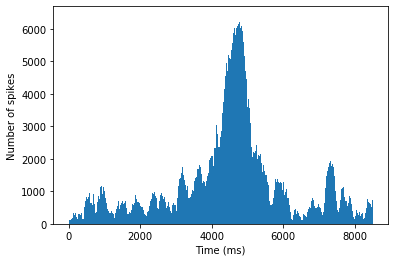

In [25]:
# exercise
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(t / 1000, bins=1000)
plt.xlabel('Time (ms)')
plt.ylabel('Number of spikes')

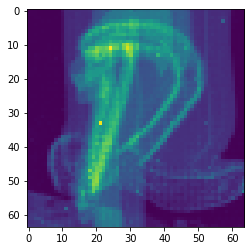

In [11]:
# exercise
hist = np.histogramdd((x, y), bins=64)[0]
plt.imshow(hist)

Now we'll **put this event-based data aside** and use accumulated data, in order to train a normal CNN. I've turned this event-based data into a frame-based video, and we'll use these frames for training.

## Loading and understanding the training data

The data is stored in a folder of images, as often done while training neural networks. Each subfolder coincides with a class, and contains .png files of training examples. These are **frames**, not events. We are training a normal CNN, for now.

We use a standard Torchvision dataset and dataloaders to read the data into PyTorch. The transformation is needed to provide images with the correct scale and a single channel.

In [19]:
from torchvision.transforms import ToTensor, RandomAffine
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

FOLDER = './train'
BATCH_SIZE = 256

rescaler = RandomAffine(0, scale=(0.8, 1.0), translate=(0.1, 0.1))

def transform(image):
    image = rescaler(image)
    return ToTensor()(image)[0].unsqueeze(0) * 255

train_dataset = ImageFolder(
    root=FOLDER,
    transform=transform,
)

print("Number of training frames:", len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Number of training frames: 192995


The `train_dataset` object contains all our training images and labels, which are loaded into batches by the `train_dataloader` object.

Using `train_dataset`, try looking at how the data looks like. Plot one of the samples, which are 64x64 images, and print the corresponding label.

label: 2


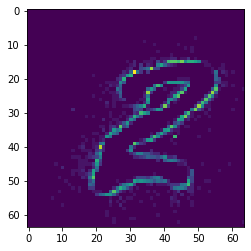

In [20]:
# exercise
sample, label = train_dataset[51110]

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sample.squeeze())  # remove the extra dimension
print('label:', label)

## Defining a model

We now define our convolutional neural network. It will be a small network with 3 convolutional layers and one fully connected. Note that so far we are doing the exact same thing that we would do with traditional deep networks. There are no spikes yet.

In [0]:
from torch import nn
import torch

class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.seq = nn.Sequential(*[
            nn.Conv2d(in_channels=1, out_channels=8,
                      kernel_size=(3, 3), bias=False),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(in_channels=8, out_channels=32,
                      kernel_size=(3, 3), bias=False),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=16,
                      kernel_size=(3, 3), bias=False),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout2d(0.5),
            nn.Flatten(),
            nn.Linear(576, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 10, bias=False),
            nn.ReLU(),
        ])

    def forward(self, x):
        return self.seq(x)

## Main training phase

We now want to train this network. Once again, this is no different from training a normal CNN -- it *is* a normal CNN. Only later, we will turn this network into a spiking network.

The next two cells implement the following, in PyTorch:
 - instantiate the model and copy it to the GPU
 - instantiate the loss (cross entropy?)
 - instantiate an optimizer
 - write a training loop
 - train for an epoch or two, checking that the loss improves
 - test (on the training set, for simplicity)

In [0]:
# instantiating the model and transferring to GPU
model = MNISTClassifier()
model.cuda()

# defining the loss function
criterion = torch.nn.CrossEntropyLoss()

# defining the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
# Set up a training loop
from tqdm import tqdm_notebook as tqdm
n_epochs = 1

for epoch in range(n_epochs):
    print("Epoch", epoch+1)
    progress_bar = tqdm(train_dataloader)
    for (images, labels) in progress_bar:
        # move to the GPU
        images = images.cuda()
        labels = labels.cuda()
        
        # reset the gradients
        optimizer.zero_grad()
        
        # forward pass through the network
        outputs = model(images)
        
        # compute and backpropagate the loss
        loss_value = criterion(outputs, labels)
        loss_value.backward()
        optimizer.step()
        progress_bar.set_postfix(LOSS=loss_value.item())

    # quickly test on one batch of the training set
    _, predictions = torch.max(outputs, axis=1)
    fraction_correct = (predictions == labels).sum().item() / BATCH_SIZE
    print("Accuracy on training set:", fraction_correct)
        
    # save the network, just in case
    torch.save(model.state_dict(), 'digits_net.pth')

Epoch 1



Accuracy on training set: 0.78515625


## Converting to a spiking network

To convert to a spiking network, we use the `from_torch` tool from `sinabs`, which reads a network (must be sequential, and only certain layers are supported), and converts it to the `sinabs` Network object, which supports all the dynamics of neurons on top of the convolutions.

First, we reload our weights, if necessary

In [26]:
# reload the model from saved, if necessary
model.load_state_dict(torch.load('digits_net.pth'))

<All keys matched successfully>

Turn the model into a spiking network with sinabs's tool

In [27]:
from sinabs.from_torch import from_model

net = from_model(
    model.seq,
    input_shape=(1, 64, 64),
    threshold=1.0,
    membrane_subtract=1.0,
    threshold_low=-5.0,
).cuda()

conv2d_0 (8, 62, 62)
avgpool_1 (8, 31, 31)
conv2d_2 (32, 29, 29)
avgpool_3 (32, 14, 14)
conv2d_4 (16, 12, 12)
avgpool_5 (16, 6, 6)
flatten (576,)
linear_7 (32,)
linear_8 (10,)


/usr/local/lib/python3.6/dist-packages/sinabs/from_torch.py:351: UserWarning: Layer 'Dropout2d' is not supported. Skipping!
  warn(f"Layer '{type(module).__name__}' is not supported. Skipping!")


## Preparing the data for testing

When using our neuromorphic chips, we will feed the DVS events to the network one by one, live, as soon as they are received. However, here, we are only simulating the chip, and it's necessary to have a finite time step.

To simulate the very high frame rate, we feed 10 milliseconds long frames to the network.

In [29]:
import torch

# time bin size
TIMESTEP_LENGTH = 10  # milliseconds

ms_frames = np.histogramdd((t, x, y), bins=(np.arange(t.min(), t.max(), 1000 * TIMESTEP_LENGTH), 64, 64))[0]
ms_frames = torch.tensor(ms_frames).float().unsqueeze(1).cuda()

print(ms_frames.shape)

torch.Size([850, 1, 64, 64])


The dimensions of `ms_frames` correspond to (time, channels, height, width).

As an exercise, pass these time steps (or some of them) into the network (calling `net(...)`) and read the output. The output will be a tensor of dimensions (time, output_neuron_number). Each output neuron corresponds to a digit from 0 to 9, the predicted number recorded in the data.

In [0]:
#exercise
output = net(ms_frames).cpu().numpy()


Now, find a good way to see what's the network's prediction and whether it changes in time. The **maximally active neuron** corresponds to the network's prediction at a given time. Try answering:

- which two digits were shown to the sensor?
- when did I change from one digit to the other?

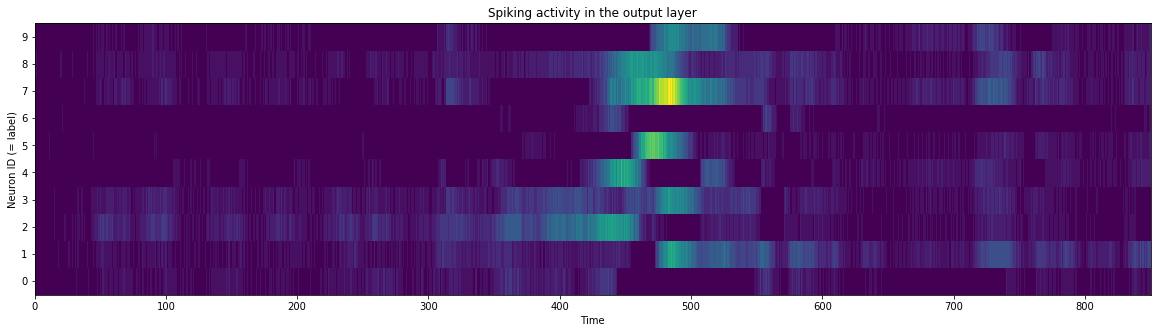

In [36]:
# exercise
plt.figure(figsize=(20, 5))
plt.pcolormesh(output.T)
plt.title('Spiking activity in the output layer')
plt.xlabel('Time')
plt.ylabel('Neuron ID (= label)')
plt.yticks(np.arange(10)+0.5, np.arange(10));

Text(0.5, 0, 'Time')

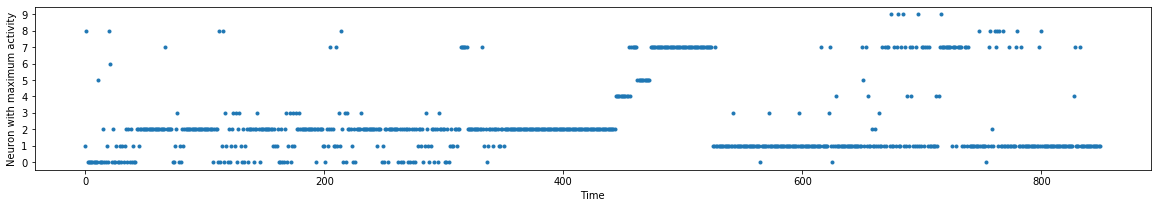

In [41]:
# exercise
predicted_class = np.argmax(output, axis=1)

plt.figure(figsize=(20, 3))
plt.plot(predicted_class, '.')
plt.yticks(np.arange(10), np.arange(10));
plt.ylabel("Neuron with maximum activity")
plt.xlabel("Time")

You should see one neuron being particularly active in the first part of the video, and another one in the second part. These correspond to the digits shown to the DVS in the video!

## Estimating power consumption

Sinabs can count the number of synaptic operations performed in the last forward pass. We estimate an energy consumption of 10 pJ per synaptic operation for our chips; multiplied by the number of SynOps per second, we get the power consumption during the video analysis.

Note that if nothing was happening in the video, there would be close to no energy use at all.

Also consider that we did nothing to encourage the network to keep the number of SynOps low! Better results can be achieved by optimising in this direction.

In [0]:
# useful constants that describe the power consumption of our chip
SYNOP_POWER = 10e-8  # millijoules

In [ ]:
# prints a summary of operations in each layer
net.get_synops(0)['SynOps']

In [42]:
total_synops = net.get_synops(0)['SynOps'].sum()
synops_per_millisecond = total_synops / len(ms_frames) / TIMESTEP_LENGTH
synops_per_second = synops_per_millisecond * 1000
power_consumption_mW = synops_per_second * SYNOP_POWER

print('Mean power consumption (mW):', power_consumption_mW)

Mean power consumption (mW): 30.792801482352942


# Improving

- Better training procedures can be implemented specifically for spiking networks, but they are far slower, involving backpropagation through time. For certain tasks, and when optimizing for energy, these are a better option.
- Power consumption has not been optimized at all
- Other tasks, such as the analysis of audio or longer videos, require better techniques than frame-based training. In the afternoon we will see demos that use recurrent networks for this purpose.

## Final tasks

Try improving the energy consumption by reducing the number of spikes. To do this, you can **manually rescale the weights of the first convolutional layer** after training. See how the energy consumption changes, and how the accuracy decreases, if it does. You can also try changing the network structure as you please.